In [34]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 텐서플로우를 활용한 선형 회귀분석
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

In [35]:
df=pd.read_csv('./data/titanic/test.csv', header=0)
print(df.shape)
df.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# 데이터 전처리

In [36]:
# 나이를 예측하기 위해서 관련없는 columns 제거

# 결측치가 많은 Cabin을 없애고 Embarked의 결측치를 제거
# Cabin 열 제거
df.drop('Cabin', axis=1, inplace=True)

# Embarked 열의 결측치 제거
df.dropna(subset=['Embarked'], inplace=True)



# PassengerID, Name, Ticket 열 제거
df.drop('PassengerId', axis=1, inplace=True)
df.drop('Name', axis=1, inplace=True)
df.drop('Ticket', axis=1, inplace=True)


print(df.shape)
df.isnull().sum()

(418, 7)


Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

In [37]:
# gender를 0과 1로 매핑
gender_map = {'male': 0, 'female': 1}
df['Sex'] = df['Sex'].map(gender_map)

# Embarked를 0,1,2로 매핑
Embarked_map = {'S': 1, 'C': 2, 'Q': 3}
df['Embarked'] = df['Embarked'].map(Embarked_map)

df_origin= df.copy()

df.head()


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,34.5,0,0,7.8292,3
1,3,1,47.0,1,0,7.0000,1
2,2,0,62.0,0,0,9.6875,3
3,3,0,27.0,0,0,8.6625,1
4,3,1,22.0,1,1,12.2875,1


In [38]:
## AgeGroup으로 범주화
df3 = df_origin.copy()
df3["Age"] = df3["Age"].fillna(-0.5)

bins = [-1, 0, 14, 25, 35, 60, np.inf]
labels = ['Unknown', 'Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
df3['AgeGroup'] = pd.cut(df3["Age"], bins, labels = labels)


In [39]:
# df_예측 AgeGroup 및 Fare 라벨링

#Age 라벨링
age_mapping = {'Unknown': None,'Child': 1, 'Teenager': 2, 'Young Adult': 3, 'Adult': 4, 'Senior': 5}
df3['AgeGroup'] = df3['AgeGroup'].map(age_mapping)

# Age 열 제거
df3.drop('Age', axis=1, inplace=True)

#Fare 라벨링
df3['FareBand'] = pd.qcut(df3['Fare'], 4, labels = [1, 2, 3, 4])

# Fare 열 제거
df3.drop('Fare', axis=1, inplace=True)


print(df3['AgeGroup'].isnull().sum())
df3.head()


86


,Pclass,Sex,SibSp,Parch,Embarked,AgeGroup,FareBand
0,3,0,0,0,3,3.0,1
1,3,1,1,0,1,4.0,1
2,2,0,0,0,3,5.0,2
3,3,0,0,0,1,3.0,2
4,3,1,1,1,1,2.0,2


In [40]:
# 177개의 결측치 data를 test set으로 분리

# 결측치가 있는 데이터를 선택하여 따로 변수에 저장
df_age_test = df3[df3['AgeGroup'].isnull()]

# 결측치가 없는 데이터를 선택하여 훈련 데이터로 사용할 변수에 저장
df_age_train = df3[df3['AgeGroup'].notnull()]

In [41]:
from sklearn.model_selection import train_test_split

# 결측치가 없는 데이터의 AgeGroup 속성을 x_train과 y_train으로 분할
X_not_NaN = df_age_train.drop('AgeGroup', axis=1)  # 'AgeGroup' 속성을 제외한 나머지 속성을 독립 변수로 설정
y_not_NaN = df_age_train['AgeGroup']  # 'AgeGroup' 속성을 종속 변수로 설정

# 결측치가 있는 데이터의 AgeGroup 속성을 x_test와 y_test로 분할
X_in_NaN = df_age_test.drop('AgeGroup', axis=1)  # 'AgeGroup' 속성을 제외한 나머지 속성을 독립 변수로 설정
y_in_NaN = df_age_test['AgeGroup']  # 'AgeGroup' 속성을 종속 변수로 설정

X_train, X_test, y_train, y_test = train_test_split(X_not_NaN, y_not_NaN, test_size=0.2, random_state=42)


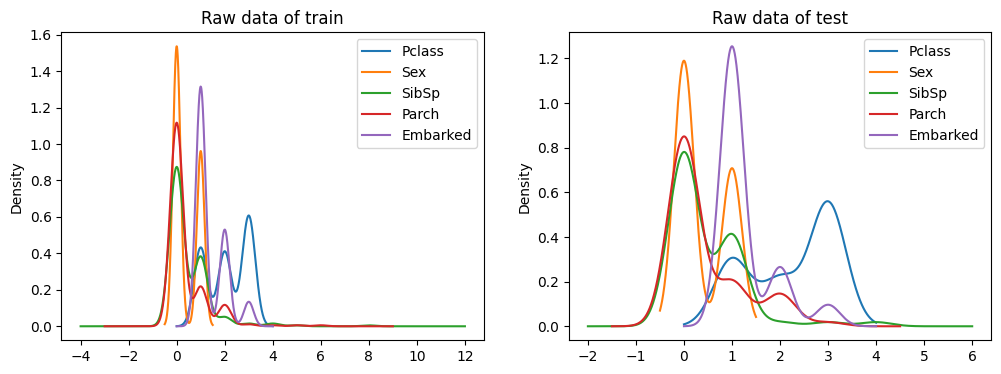

In [42]:
#범주형으로 어떻게 분포하고 있는지 한번 확인
fig, ax = plt.subplots(1,2,figsize=(12,4))
X_train.plot(kind='kde', title='Raw data of train', ax=ax[0])

X_test.plot(kind='kde', title='Raw data of test', ax=ax[1])

plt.show()


In [77]:
# 1. hidden layer 는 2개층 -> 처음 node수가 30개, 두번째 10개
# 2. 적절한 활성함수 사용'
def make_model(input_dim):
    model = Sequential()
    model.add(Dense(30, input_dim=input_dim, activation='relu'))  # 처음은 input_dim 필요
    # 두번째 layer부터는 input_dim 필요 없음, 이전 layer의 out node의 개수가 input_dim 수 
    model.add(Dense(10, activation='relu'))   
    model.add(Dense(5, activation='sigmoid'))
    
    return model

# 3. 손실함수와 옵티마이저를 sgd, adam을 사용해서 결과 비교 
model1 = make_model(X_train.shape[1])
model1.compile(loss='binary_crossentropy', optimizer='sgd',metrics=['accuracy'])

# 모델 학습
model1.fit(X_train,y_train,epochs=2000, verbose=False)


ValueError: in user code:

    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\keras\engine\training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\keras\engine\training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\keras\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\keras\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\keras\losses.py", line 2156, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\keras\backend.py", line 5707, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 5) vs (None, 1)).


In [78]:
def make_model(input_dim):
    model = Sequential()
    model.add(Dense(30, input_dim=input_dim, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(5, activation='softmax'))  # 클래스 개수에 맞게 출력 노드 개수와 활성화 함수 변경
    
    return model

model = make_model(X_train.shape[1])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # 손실 함수 변경

model.fit(X_train, y_train, epochs=2000, verbose=False)


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\rhkr3\AppData\Local\Temp\ipykernel_32656\169920947.py", line 12, in <module>
      model.fit(X_train, y_train, epochs=2000, verbose=False)
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\keras\engine\training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\keras\engine\training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\keras\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\keras\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\keras\losses.py", line 2078, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "c:\Users\rhkr3\anaconda3\envs\py3.8\lib\site-packages\keras\backend.py", line 5660, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of 5 which is outside the valid range of [0, 5).  Label values: 2 4 1 3 2 1 2 4 4 3 5 5 3 2 4 4 2 1 4 2 2 3 2 4 4 3 4 4 4 4 3 3
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_292110]

In [76]:
model1.predict(X_train)

9/9 [==============================] - 0s 1ms/step


array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
      

In [66]:
print(model1.history.history['loss'][-1])  # 마지감 손실함수의 값 출력
# 데이터 예측

predict_result = model1.predict(X_train[-1].reshape(1,-1))
print(f"실제 값 :{y_train[-1]},  예측 값 : {predict_result }")

nan


KeyError: -1